In [66]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [67]:
df_owd = pd.read_csv("./dataset/1990-2020_day.csv", parse_dates=True)
df_owd['dt_iso'] = pd.to_datetime(df_owd['dt_iso'])
df_owd.head()

,dt_iso,temp_mean,temp_min_min,temp_max_max,pressure_mean,humidity_mean,wind_speed_mean,wind_deg_mean,clouds_all_mean,rain_1d
0,1990-01-01,26.333750,25.03,27.40,1009.333333,85.416667,1.477083,194.291667,91.541667,9.40
1,1990-01-02,25.559583,24.92,26.55,1009.666667,87.541667,2.096667,247.458333,99.958333,36.71
2,1990-01-03,26.956667,26.09,27.52,1008.583333,82.250000,2.122083,271.125000,96.000000,5.02
3,1990-01-04,26.638750,25.91,27.15,1007.958333,84.541667,2.652500,202.458333,98.541667,10.54
4,1990-01-05,27.940417,27.40,28.83,1007.916667,78.708333,2.905000,131.458333,99.708333,0.71


## EDA

Pola curah hujan dalam satu tahun

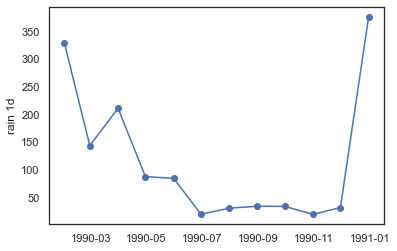

In [68]:
df_1990 = df_owd[(df_owd['dt_iso'] >= '1990-01-01') & (df_owd['dt_iso'] <= '1990-12-31')]
plt.plot(df_1990.groupby([pd.Grouper(key='dt_iso', freq='M')]).rain_1d.sum(), marker='o')
plt.ylabel("rain 1d")
plt.show()

Dari plot terlihat data mengikuti pola yang valid

- Denpasar mengikuti pola Monsoon, 
- Puncak musim hujan berada di **Dec-Jan-Feb (DJF)**
- Puncak musim kemarau berada di **Jun-Jul-Aug (JJA)**

<img src='images/pola.jpeg'></img>

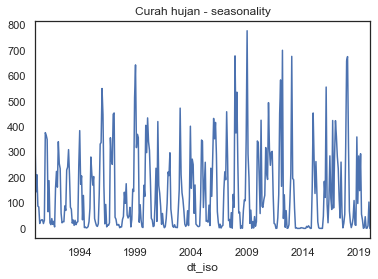

In [69]:
df_owd.groupby([pd.Grouper(key='dt_iso', freq='M')]).rain_1d.sum().plot()
plt.title('Curah hujan - seasonality')
plt.show()

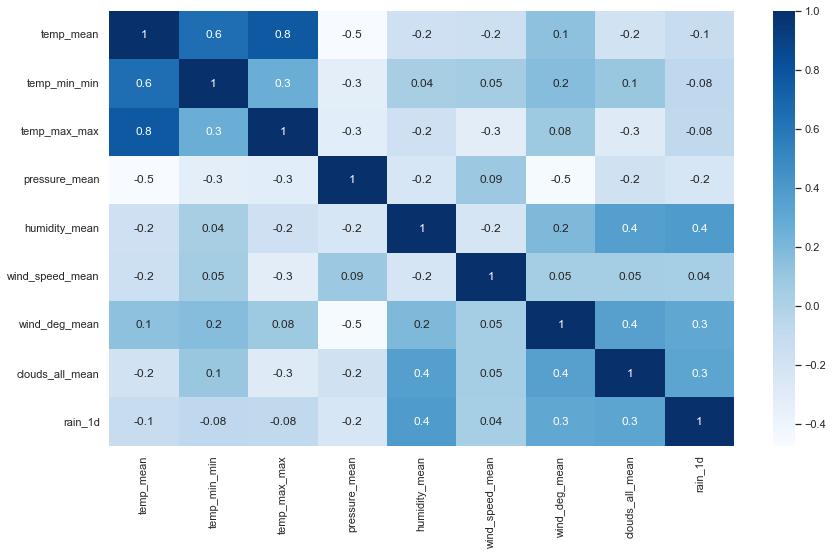

In [70]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = df_owd.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')

Hasil korelasi parameter tidak ada korelasi yang kuat antara curah hujan dan parameter lainnya

Namun pada riset ini diangkut semua paramater karena parameter tersebut yang biasa dipakai dalam prediksi curah hujan

### Dataset Statistik

In [71]:
df_owd.describe()

,temp_mean,temp_min_min,temp_max_max,pressure_mean,humidity_mean,wind_speed_mean,wind_deg_mean,clouds_all_mean,rain_1d
count,10964.000000,10964.000000,10964.000000,10964.000000,10964.000000,10964.000000,10964.000000,10964.000000,10964.000000
mean,27.273347,24.848543,30.145240,1010.043557,80.814358,3.615097,157.916497,38.428085,4.545826
std,1.069445,1.391260,1.551929,1.995368,4.300660,1.394986,63.101959,14.729778,12.830629
min,22.401250,2.000000,23.200000,1001.129167,61.958333,0.998333,48.000000,6.083333,0.000000
25%,26.510208,24.000000,29.000000,1008.719792,78.125000,2.560729,111.291667,28.333333,0.000000
50%,27.337500,25.000000,30.000000,1010.125000,80.875000,3.402708,124.833333,35.000000,0.180000
75%,28.070729,25.800000,31.000000,1011.483333,83.666667,4.399271,207.666667,44.541667,2.310000
max,31.339167,28.800000,39.800000,1017.037500,98.000000,12.765833,321.250000,100.000000,221.000000


Terlihat terjadi data error pada temperatur minimum, tidak mungkin di daerah Denpasar mengalami suhu 2 derajat

Oleh karena itu, dilakukan cleansing dengan mengganti nilai temp_min_min < 22.4 dengan nilai 22.4 yaitu diambil dari temperture_mean minimum

### Cleansing

In [72]:
df_owd.loc[(df_owd['temp_min_min'] < 22.4), 'temp_min_min'] = 22.4

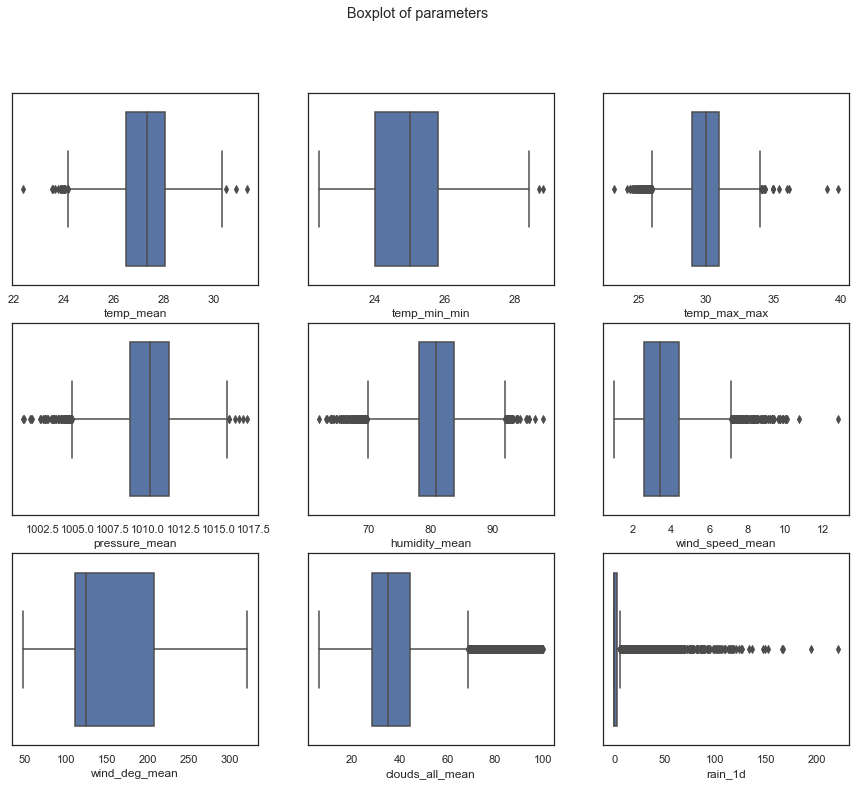

In [73]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Boxplot of parameters')
i, j = 0, 0
for c in df_owd:
    if c != 'dt_iso':
        sns.boxplot(ax=axes[i, j], x=df_owd[c])

        j = j + 1
        if j >= 3:
            j = 0
            i = i + 1

Dari boxplot dapat dilihat bahwa yang mendekati distribusi normal hanyalah **temp_mean, pressure_mean, humidity_mean dan wind_deg_mean**

Sehingga untuk keseragaman maka normalisasi tidak menggunakan z-score melainkan min-max,  

## Preprocess

In [74]:
df_owd_train = df_owd[(df_owd['dt_iso'] <= '2018-12-31')]
df_owd_test = df_owd[(df_owd['dt_iso'] >= '2019-01-01') & (df_owd['dt_iso'] <= '2019-12-31')] # ignore 2020

In [75]:
df_owd = df_owd.set_index('dt_iso')
df_owd_train = df_owd_train.set_index('dt_iso')
df_owd_test = df_owd_test.set_index('dt_iso')

In [76]:
sc = MinMaxScaler(feature_range = (0, 1))
norm_df_owd = sc.fit_transform(df_owd_train)

# norm_df_owd = (df_owd - df_owd.min(axis=0)) / (df_owd.max(axis=0) - df_owd.min(axis=0))
norm_df_owd

array([[0.43997949, 0.4109375 , 0.25301205, ..., 0.53537664, 0.90993789,
        0.04253394],
       [0.35336348, 0.39375   , 0.20180723, ..., 0.72994815, 0.99955634,
        0.1661086 ],
       [0.50967321, 0.5765625 , 0.26024096, ..., 0.81655993, 0.95740905,
        0.02271493],
       ...,
       [0.6979628 , 0.625     , 0.48192771, ..., 0.83074108, 0.26796806,
        0.01900452],
       [0.68220596, 0.5625    , 0.48192771, ..., 0.81091796, 0.17258208,
        0.        ],
       [0.70807888, 0.5625    , 0.53012048, ..., 0.41445563, 0.42502218,
        0.01040724]])

In [77]:
# norm_df_owd = norm_df_owd.reset_index()

### Windowing dataset

In [78]:
# #Empty lists to be populated using formatted training data
# trainX = []
# trainY = []

# n_future = 30   # Number of days we want to look into the future based on the past days.
# n_past = 60  # Number of past days we want to use to predict the future.
# n_feature = 9

# #Reformat input data into a shape: (n_samples x timesteps x n_features)
# #In my example, my df_for_training_scaled has a shape (12823, 5)
# #12823 refers to the number of data points and 5 refers to the columns (multi-variables).
# for i in range(n_past, len(norm_df_owd) - n_future + 1):
#     trainX.append(norm_df_owd[i - n_past:i, 0:norm_df_owd.shape[1]]) # input multi var
#     trainY.append(norm_df_owd[i + n_future - 1:i + n_future, norm_df_owd.shape[1]- 1]) # output 1 var

# trainX, trainY = np.array(trainX), np.array(trainY)

# print('trainX shape == {}.'.format(trainX.shape))
# print('trainY shape == {}.'.format(trainY.shape))

In [79]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [80]:
past_history = 730
future_target = 365
n_feature = 9
STEP = 1 # 6
TRAIN_SPLIT = 9496 # 2016
x_train_multi, y_train_multi = multivariate_data(norm_df_owd, norm_df_owd[:, 8], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(norm_df_owd, norm_df_owd[:, 8],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

## Model

In [81]:
model = keras.models.Sequential([
  keras.layers.Bidirectional(keras.layers.GRU(units=32, return_sequences = True, input_shape=(past_history, n_feature))),
  keras.layers.Dropout(0.2),
  keras.layers.Bidirectional(keras.layers.GRU(units=32)),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(units = future_target)
])

In [82]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [83]:
epoch = 10
batch_size = 128
model.fit(x_train_multi, y_train_multi, validation_data=(x_val_multi, y_val_multi), epochs = epoch, batch_size = batch_size)

Epoch 1/10
69/69 [==============================] - 115s 2s/step - loss: 0.0044 - val_loss: 0.0034
Epoch 2/10
69/69 [==============================] - 115s 2s/step - loss: 0.0035 - val_loss: 0.0032
Epoch 3/10
69/69 [==============================] - 116s 2s/step - loss: 0.0034 - val_loss: 0.0031
Epoch 4/10
69/69 [==============================] - 117s 2s/step - loss: 0.0034 - val_loss: 0.0031
Epoch 5/10
69/69 [==============================] - 125s 2s/step - loss: 0.0034 - val_loss: 0.0031
Epoch 6/10
69/69 [==============================] - 117s 2s/step - loss: 0.0033 - val_loss: 0.0031
Epoch 7/10
69/69 [==============================] - 112s 2s/step - loss: 0.0033 - val_loss: 0.0031
Epoch 8/10
69/69 [==============================] - 114s 2s/step - loss: 0.0033 - val_loss: 0.0031
Epoch 9/10
69/69 [==============================] - 114s 2s/step - loss: 0.0032 - val_loss: 0.0030
Epoch 10/10
69/69 [==============================] - 114s 2s/step - loss: 0.0032 - val_loss: 0.0030


In [92]:
model.save('model.h5')

### Testing

In [85]:
X_predict = norm_df_owd[-past_history:].reshape((-1, past_history, n_feature))

In [86]:
hasil = model.predict(X_predict)

1/1 [==============================] - 1s 1s/step


In [87]:
max = sc.data_max_[-1]
min = sc.data_min_[-1]
y_descaled = hasil * (max - min) + min
y_descaled

array([[ 9.762445  ,  8.6962805 ,  9.290946  ,  9.314777  , 10.179439  ,
         7.899721  , 10.236093  ,  9.09561   ,  9.263567  ,  9.119138  ,
         9.127122  ,  9.891286  ,  9.553597  ,  9.205597  ,  8.355533  ,
         8.720142  ,  8.476352  ,  8.4603815 ,  8.535216  ,  8.17981   ,
         8.568775  ,  8.381591  ,  7.980435  ,  8.36871   ,  7.8289547 ,
         8.721767  ,  8.789885  ,  9.28109   ,  9.404612  ,  8.418107  ,
         8.341468  ,  9.881922  ,  8.183742  ,  7.905501  ,  8.467431  ,
         8.552611  ,  8.923276  ,  8.966555  ,  8.084666  ,  8.281236  ,
         6.9993806 ,  8.196186  ,  7.0373225 ,  9.346029  ,  6.831946  ,
         6.762072  ,  7.814392  ,  6.6684666 ,  7.042748  ,  7.2383747 ,
         7.140488  ,  7.4823737 ,  6.8979316 ,  6.5265746 ,  6.101822  ,
         6.5641856 ,  7.098439  ,  6.922411  ,  6.1984563 ,  6.429017  ,
         6.279032  ,  5.7350583 ,  6.6087914 ,  5.506075  ,  6.0312757 ,
         6.237228  ,  5.836634  ,  4.791067  ,  5.2

In [88]:
total_1d_predicted = pd.Series(y_descaled.flatten(), name='total_1d_predicted')

df_owd_test = df_owd_test.reset_index()
aggregated_2019_df = pd.concat([df_owd_test, total_1d_predicted], axis=1)

In [89]:
rain_1M_2019 = aggregated_2019_df.groupby([pd.Grouper(key='dt_iso', freq='M')]).rain_1d.sum()
rain_1M_2019_pred = aggregated_2019_df.groupby([pd.Grouper(key='dt_iso', freq='M')]).total_1d_predicted.sum()

# (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
rain_1M_2019 = (rain_1M_2019 - min) / (max - min)
rain_1M_2019_pred = (rain_1M_2019_pred - min) / (max - min)
mse = ((rain_1M_2019_pred - rain_1M_2019) ** 2).sum() / 12
print(mse)

0.209137301429938


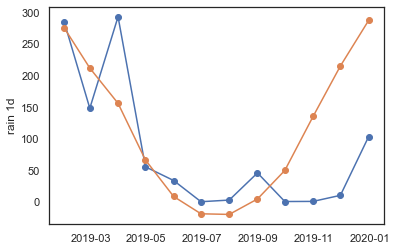

In [90]:
plt.plot(aggregated_2019_df.groupby([pd.Grouper(key='dt_iso', freq='M')]).rain_1d.sum(), marker='o')
plt.plot(aggregated_2019_df.groupby([pd.Grouper(key='dt_iso', freq='M')]).total_1d_predicted.sum(), marker='o')
plt.ylabel("rain 1d")
plt.show()

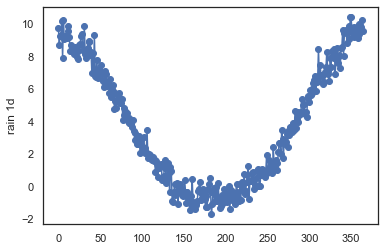

In [91]:
plt.plot(y_descaled.flatten(), marker='o')
plt.ylabel("rain 1d")
plt.show()